In [1]:
#importing all relevant libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import time
import csv
#for a preferred view of graph format
plt.style.use('fivethirtyeight')

In [2]:
#load the data and store it in a dataframe
#defining variables that can be changed accordingly in the https request to get different company or different time data
ticker = 'HINDUNILVR.NS'
period1_1 = int(time.mktime(datetime.datetime(2016, 8, 6, 23, 59).timetuple()))
period1_2 = int(time.mktime(datetime.datetime(2021, 8, 6, 23, 59).timetuple()))
interval = '1d' # 1d, 1m

#query string is for http request to yahoo finance that uses f string to get data according to variables
query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1_1}&period2={period1_2}&interval={interval}&events=history&includeAdjustedClose=true'

#storing required csv file in dataframe
df = pd.read_csv(query_string)
#to check if csv file was successfully extracted to the data frame
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-08-08,926.549988,934.349976,922.400024,929.500000,863.067200,640018.0
1,2016-08-09,929.500000,935.900024,924.150024,934.250000,867.477722,912239.0
2,2016-08-10,935.000000,935.349976,922.799988,924.950012,858.842346,675289.0
3,2016-08-11,924.900024,938.099976,922.549988,935.650024,868.777649,859803.0
4,2016-08-12,934.799988,947.000000,926.000000,935.000000,868.174011,664203.0


In [3]:
#Now we'll create a new data frame that holds exponential moving averages of required duration
EMA5=df['Adj Close'].ewm(span=5, adjust = False).mean()    #the momentum indicator. 
EMA21=df['Adj Close'].ewm(span=21, adjust = False).mean()  #what we use for comparision
EMA63=df['Adj Close'].ewm(span=63, adjust = False).mean()  #for the longer term trend.

In [4]:
#creating new columns in the dataframe to store above exponential means
df['Short']=EMA5
df['Middle']=EMA21
df['Long']=EMA63

In [5]:
#checking if we successfully added the columns
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Short,Middle,Long
0,2016-08-08,926.549988,934.349976,922.400024,929.500000,863.067200,640018.0,863.067200,863.067200,863.067200
1,2016-08-09,929.500000,935.900024,924.150024,934.250000,867.477722,912239.0,864.537374,863.468157,863.205029
2,2016-08-10,935.000000,935.349976,922.799988,924.950012,858.842346,675289.0,862.639031,863.047628,863.068695
3,2016-08-11,924.900024,938.099976,922.549988,935.650024,868.777649,859803.0,864.685237,863.568539,863.247100
4,2016-08-12,934.799988,947.000000,926.000000,935.000000,868.174011,664203.0,865.848162,863.987219,863.401066


In [6]:
#the trading logic(more elaboration in the summary file)

def buy_sell(data):
    
    buy_list = []
    sell_list = []
    flag_long = False
    flag_short = False
    stop_loss = False
    buy_price=0
    
    for i in range(0,len(data)):
        if((flag_long == True or flag_short == True) and (data["Adj Close"][i]<0.85*(buy_price)) and stop_loss==False):
            stop_loss = True
            sell_list.append(data['Adj Close'][i])
            buy_list.append(np.nan)
            flag_short = False
            flag_long = False
        if data["Short"][i] < data["Middle"][i] and data["Middle"][i] < data["Long"][i] and flag_long == False and flag_short==False :
            buy_list.append(data['Adj Close'][i])
            sell_list.append(np.nan)
            flag_short = True
            buy_price = data['Adj Close'][i]
            stop_loss = False
        elif flag_short == True and data["Short"][i] > data["Middle"][i] and stop_loss == False : 
            sell_list.append(data["Adj Close"][i])
            buy_list.append(np.nan)
            flag_short = False
        if data["Short"][i] > data["Middle"][i] and data["Middle"][i] > data["Long"][i] and flag_long == False and flag_short==False :
            buy_list.append(data['Adj Close'][i])
            sell_list.append(np.nan)
            flag_long = True
            buy_price = data['Adj Close'][i]
            stop_loss = False
        elif flag_long == True and data["Short"][i] < data["Middle"][i] and stop_loss == False : 
            sell_list.append(data["Adj Close"][i])
            buy_list.append(np.nan)
            flag_long = False
        else : 
            buy_list.append(np.nan)
            sell_list.append(np.nan)
            
    return (buy_list,sell_list)


In [7]:
#creating two lists to store the data of the trading
Buy=buy_sell(df)[0]
Sell=buy_sell(df)[1]

In [8]:
#printing and checking if data was successfully stored in the lists
for i in range(0,len(Buy)):
    print(str(Buy[i])+"         "+str(Sell[i]))

nan         nan
867.477722         nan
nan         858.842346
868.777649         nan
nan         nan
nan         nan
nan         847.932251
842.082458         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         870.820313
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
843.521606         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan         nan
nan    

In [9]:
#this is to make sure if there is no stray buy signal towards the end without a sell signal proceeding it and if it is there then replace it with nan value
for i in range(len(Buy)-1,-1,-1):
    if(np.isnan(Buy[i])==False and np.isnan(Sell[i])==True):
        c=1
        t=i
        break
    elif(np.isnan(Buy[i])==True and np.isnan(Sell[i])==False):
        c=0
        break
if(c==1):
    Buy[t]=float("nan")

In [10]:
#this block works to create a PnL_per_trade list to save PnL values per trade
list=[]
buy_sell_ratio=[]
for i in range(0,len(Buy)):
    if(np.isnan(Buy[i])==False and np.isnan(Sell[i])==True):
        c=1
        t=i
    elif(np.isnan(Buy[i])==True and np.isnan(Sell[i])==False):
        c=-1
        z=i
    if(c==-1):
        list.append(0.99*Sell[z]-Buy[t])
        buy_sell_ratio.append(0.99*Sell[z]/Buy[t])
        c=0
PnL_per_trade = [x for x in list if np.isnan(x) == False]
ratio_per_trade = [x for x in buy_sell_ratio if np.isnan(x) == False]

In [11]:
#this block displays PnL_per_trade
PnL_per_trade

[-17.22379946000001,
 -29.32472051000002,
 20.029651870000066,
 -66.83433893000006,
 -4.404183639999928,
 -25.761745089999977,
 38.44192240999996,
 262.70914687999993,
 -9.537625180000077,
 56.29137433000005,
 25.02997882999989,
 291.36470388,
 -51.74879523000004,
 23.18186216999993,
 95.7936169699999,
 -62.553658810000115,
 4.46474846000001,
 82.74601753000002,
 -8.546485529999927,
 -47.250636389999954,
 44.60462991999998,
 -52.41242439000007,
 -33.558464390000154,
 86.62569944999996,
 41.27842364999992,
 89.01274161000038,
 -114.83935779000012,
 273.98407449000024,
 -11.024419240000043,
 72.94920180999975,
 20.108667349999678,
 8.67991185999972,
 -44.03753645000006,
 -101.49242953999988,
 42.92371291000018,
 123.03370394000012,
 -131.00622755999984,
 -7.30563962000042,
 -33.68369419000055,
 -100.16467727000008,
 28.989927019999868]

In [12]:
ratio_per_trade

[0.9801449662358015,
 0.9662460002927631,
 1.0237858557433577,
 0.9207674842533908,
 0.9942765939762856,
 0.9680217023369703,
 1.048047817148652,
 1.3036396365952374,
 0.991865315884283,
 1.0472477307034207,
 1.0203548063113712,
 1.2272341591254041,
 0.9680155710982031,
 1.0152131502099897,
 1.0594912924847786,
 0.963919845932276,
 1.0027259534995894,
 1.0514560012935474,
 0.9949840766804597,
 0.9727206413532974,
 1.027345225926445,
 0.9706715161581206,
 0.9810969181813112,
 1.045313476791781,
 1.021738585311109,
 1.044230797609919,
 0.9469275040305479,
 1.1527739062526787,
 0.994826627936427,
 1.037173202550865,
 1.009979984497074,
 1.0040481621117043,
 0.9793566503810762,
 0.9525148043765062,
 1.0208659714771415,
 1.056706669933852,
 0.9452324772579811,
 0.9966492874975488,
 0.985367283980935,
 0.9580771516091703,
 1.0122749645472175]

In [13]:
#this block helps us get the overall profit and loss
sum=0
loss=0
win=0
initial_sum=100000
for i in range(0,len(PnL_per_trade)):
    sum+=PnL_per_trade[i]
    initial_sum*=ratio_per_trade[i]
    if(ratio_per_trade[i]<1):
        loss+=1
    else:
        win+=1
sum

779.5328581299982

In [14]:
initial_sum

176574.74974134844

In [15]:
win/loss

1.05

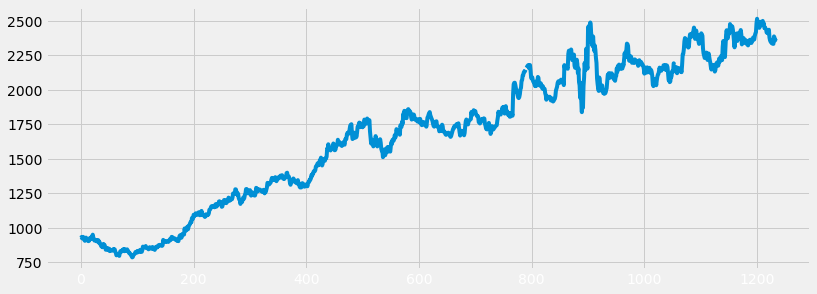

In [16]:
#graph
plt.figure(figsize=(12.2,4.5))
plt.plot(df['Close'])
plt.xticks(color='w')
plt.show()

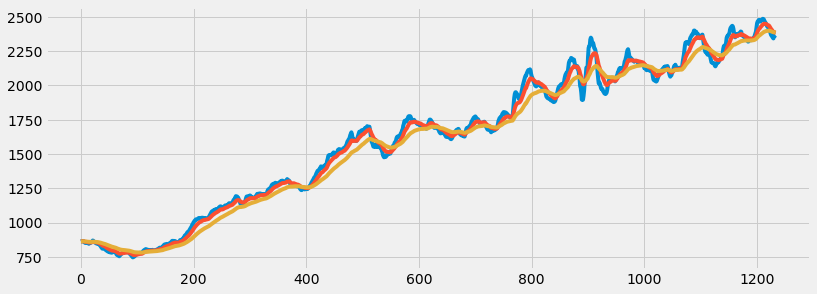

In [17]:
plt.figure(figsize=(12.2,4.5))
plt.plot(df["Short"])
plt.plot(df["Middle"])
plt.plot(df["Long"])
plt.show()

In [18]:
#we create a Position list having String values to see if the position is Long or nuetral
Position=[]
c=-1
for i in range(0,len(Buy)):
    if(np.isnan(Buy[i])==False and np.isnan(Sell[i])==True):
        c=1
    elif(np.isnan(Buy[i])==True and np.isnan(Sell[i])==False):
        c=-1
    if(c==1):
        Position.append("Long")
    elif(c==-1):
        Position.append("Neutral")

In [19]:
#to generate csv files of the indicator and position data
with open('2020-2021.csv','w',newline='') as f:
    thewriter = csv.writer(f)
    thewriter.writerow(['Date','EMA5','EMA21','EMA63',"Position"])
    for i in range(0,len(df)):
        thewriter.writerow([df["Date"][i],df["Short"][i],df["Middle"][i],df["Long"][i],Position[i]])